## <a id='table-of-contents'></a>Table of contents
1. [Import Libraries](#imports)
2. [Load Data](#load-data)
3. [Pre-processing: Scans](#scan-info)
4. [Pre-processing: Errors](#error-info)
5. [Motor 1 EDA](#m1-info)
6. [Motor 2 EDA](#m2-info)
7. [Conversion: Time Delay](#time-delay)
8. [Figure 1: No Dash](#figure1)
9. [Figure 2: Option3](#figure2)
10. [Figure 3: Not my figure](#figure3)
11. [Figure 4: Subplots](#figure4)

### Import Libraries and Modules


In [1]:
# Data Manipulation, Wrangling & Analysis Library 
import pandas as pd
# Multi-Dimensional Arrays and Matrices Library
import numpy as np
# Plotting module from Matplotlib visualization Library
#import matplotlib.pyplot as plt
# Statistical data visualization library built on Matplotlib
#import seaborn as sns
# Import physical constants such as the speed of light
import scipy.constants as consts

In [2]:
# Import axes_grid1 toolkit to display multiplot w/ AxesGrid helper class
#from mpl_toolkits.axes_grid1 import AxesGrid
#from mpl_toolkits.axes_grid1 import host_subplot

In [3]:
# Quick and dirty method
import plotly.express as px # (version 4.7.0)

# For more customization
import plotly.graph_objects as go

# Make subplots
from plotly.subplots import make_subplots

# Dashboard Library 'Dash' allows for button interactivity through callbacks
import dash  # (version 1.12.0) pip install dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

#### Render Plotly graphs in JupyterLab Notebook
[*Stack Overflow*](https://stackoverflow.com/questions/54936125/plotly-gives-an-empty-field-as-output-in-jupyter-lab)

JupyterLab Version >= 3.0.0:<br> 
$ jupyter labextension install jupyterlab-plotly

Verify:<br>
$ jupyter labextension list
---

<a id = 'load-data'></a>
### Load Data

[[ go back to the top ]](#Table-of-contents)

In [4]:
# Identify column names for new DataFrame
header_names = ['#errors',
                'scan#', 
                'motor-target_1', # Motor-1 targeted motor position
                'motor-target_2', # Motor-2 targeted motor position
                'motor-actual_1', # Motor-1 actual recorded position
                'motor-actual_2', # Motor-2 actual recorded position
                'data_channel_0', 
                'data_channel_1', 
                'data_channel_2',
                'data_channel_3',
                'data_channel_4',
                'data_channel_5',
                'data_channel_6',
                'data_channel_7']

# Read tsv data and assign to a Pandas DataFrame
data = pd.read_csv('../data/trial_output05.tsv', delimiter='\t', names = header_names)

# Set dtype of scan# column to int32
data = data.astype({'scan#':int})

#### Check that all is copacetic

[[ go back to the top ]](#Table-of-contents)

In [5]:
# motor-target_1: Corresponds to Delay-Axis 1 "T"  PUMP TO DRIVE/PROBE PAIR
# motor-target_2: Corresponds to Delay-Axis 2 "Tau" DRIVE TO PROBE
data.describe()

,#errors,scan#,motor-target_1,motor-target_2,motor-actual_1,motor-actual_2,data_channel_0,data_channel_1,data_channel_2,data_channel_3,data_channel_4,data_channel_5,data_channel_6,data_channel_7
count,45628.0,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000
mean,0.0,5.378978,9.314018,33.425522,9.314025,33.425522,-0.005923,-0.006613,-0.006294,-0.006124,-0.007194,-0.006101,-0.021113,0.004937
std,0.0,3.390998,0.058022,0.050232,0.058011,0.050232,0.006699,0.022854,0.005250,0.010072,0.022253,0.009477,0.014158,0.015740
min,0.0,0.000000,9.215000,33.340000,9.215000,33.340000,-0.032503,-0.063398,-0.031538,-0.047629,-0.058893,-0.037974,-0.032503,-0.025745
25%,0.0,2.000000,9.263000,33.382000,9.263000,33.382000,-0.010298,-0.027033,-0.009654,-0.013194,-0.027033,-0.012229,-0.022849,0.003219
50%,0.0,5.000000,9.314000,33.427000,9.314000,33.427000,-0.006436,-0.008689,-0.006436,-0.007080,-0.009976,-0.007401,-0.021240,0.004828
75%,0.0,8.000000,9.365000,33.469000,9.365000,33.469000,-0.000965,0.012873,-0.002252,0.000644,0.011586,0.001288,-0.019631,0.006115
max,0.0,11.000000,9.413000,33.511000,9.413100,33.511000,0.018022,0.059537,0.016735,0.039906,0.056963,0.025424,1.671540,1.827301


---
<a id = 'scan-info'></a>

### Identify number of complete scans performed

[[ go back to the top ]](#table-of-contents)

In [6]:
# Identify # of complete scans performed
scan_info = data['scan#'].value_counts().sort_index()
num_scans = len(scan_info)
complete = max(scan_info)
complete_scans = []
incomplete_scans = []

# Count the number of measurements taken in each scan
num_m1steps = len(data['motor-target_1'].value_counts())
# Count the number of measurements taken in each scan
num_m2steps = len(data['motor-target_2'].value_counts())

# Requirements for complete scan
print(f'Complete scans have {num_m1steps*num_m2steps:,} measurements!\n')

print('scan# complete%')
display(round((data['scan#'].value_counts().sort_index()/(num_m1steps*num_m2steps))*100, 2))
print()

# Identify incomplete scans
for scan in range(num_scans):
    if scan_info[scan] != complete:
        incomplete_scans.append(scan)
    elif scan_info[scan] == complete:
        complete_scans.append(scan)
print(f'INCOMPLETE scan#: {incomplete_scans}')  
print(f'COMPLETE scan#:   {complete_scans}')  

Complete scans have 3,886 measurements!

scan# complete%


0     100.00
1     100.00
2     100.00
3     100.00
4     100.00
5     100.00
6     100.00
7     100.00
8     100.00
9     100.00
10    100.00
11     74.16
Name: scan#, dtype: float64


INCOMPLETE scan#: [11]
COMPLETE scan#:   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


---
<a id='error-info'></a>
### Check for Errors

[[ go back to the top ]](#table-of-contents)

In [7]:
# No errors identified in 45,628 measurements!
# An error may consist of a communication error b/w motor & acquisition computer
# Motors will be reinitialized, and the scan is restarted
data['#errors'].value_counts()

0.0    45628
Name: #errors, dtype: int64

---
### EDA: Characterize each Delay-Axis by Motor-Position(target)
* How many measurements were taken?
* What range was covered?
* What is the step-size of each scan?

<a id = 'm1-info'></a>
#### A.) Consider Motor-1 Targets

[ go back to the top ](#table-of-contents)

In [8]:
# Display Motor_1 Description
print(f'Motor-1 Targets: \n')

# Pre-Processing
m1_positions = sorted(data['motor-target_1'].unique())

# Determine the range of Motor_1 positions
m1_position_min = m1_positions[0]
m1_position_max = m1_positions[-1]
m1_position_range = round(m1_position_max - m1_position_min,3)

print(f'\
        Min: {m1_position_min}[mm]\n\
        Max: {m1_position_max}[mm]\n\
        Range: {m1_position_range}[mm]')

# Display the number of measurements taken in each scan
print(f'\tNo. of Steps: {num_m1steps}')

Motor-1 Targets: 

        Min: 9.215[mm]
        Max: 9.413[mm]
        Range: 0.198[mm]
	No. of Steps: 67


<a id = 'm2-info'></a>

#### B.) Consider Motor-2 Targets


In [9]:
# Display Motor-2 Description
print(f'Motor-2 Targets: \n')

# Pre-Processing
m2_positions = sorted(data['motor-target_2'].unique())

# Determine the range of Motor_1 positions
m2_position_min = m2_positions[0]
m2_position_max = m2_positions[-1]
m2_position_range = round(m2_position_max - m2_position_min, 3)

print(f'\
        Min: {m2_position_min}[mm]\n\
        Max: {m2_position_max}[mm]\n\
        Range: {m2_position_range}[mm]')

# Display the number of measurements taken in each scan
print(f'\tNo. of Steps: {num_m2steps}')

Motor-2 Targets: 

        Min: 33.34[mm]
        Max: 33.511[mm]
        Range: 0.171[mm]
	No. of Steps: 58


---
<a id = 'time-delay'></a>
### Conversion: Motor-Position [mm] to Time-Delay [fs]

[[ go back to the top ]](#table-of-contents)

#### A) Delay Axis-1: T 
##### Delay between the excitation(pump) pulse and subsequent pulses

In [78]:
# Step-size for Delay Axis-1: Round for sigfigs
sigfigs = 3
step1_space = round(m1_position_range/num_m1steps, sigfigs)

# Time, in femtoseconds[fs], it takes light to travel twice the distance "step_1"
# One femtosecond in [seconds]:
fs = 1E-15
# One thousand
K = int(1E3)
# Speed of light in [meters/second]
c = consts.c
# Laser travels twice the motor distance
twice = 2

step1_time = round((step1_space*twice / (c*K))/fs, 1)
range_T = step1_time*num_m1steps

print(f'Motor-1 Step-Size:   {step1_space}[mm]  =>  ~ {step1_time}[fs]')
print(f'Pump-Probe Time-Delay "T" Range:  ~{range_T:,}[fs]')

Motor-1 Step-Size:   0.003[mm]  =>  ~ 20.0[fs]
Pump-Probe Time-Delay "T" Range:  ~1,340.0[fs]


#### B) Delay Axis-2: <font size="5">$\tau$</font>
##### Delay between Kerr-Gating(drive) pulse and probe pulse

In [83]:
# Step-size for Delay Axis-2: Round for sigfigs
sigfigs = 3
step2_space = round(m2_position_range/num_m2steps, sigfigs)

# Time [femtoseconds] it takes light to travel twice the distance "step_2"
step2_time = round( (step2_space*twice/(c*K))/fs, 1)
range_tau = step2_time*num_m2steps

print(f'Motor-2  Step-Size:   {step2_space}[mm]  =>   ~ {step2_time}[fs]')
print(f'Drive-Probe Time-Delay "TAU" Range: ~{range_tau:,}[fs]')

Motor-2  Step-Size:   0.003[mm]  =>   ~ 20.0[fs]
Drive-Probe Time-Delay "TAU" Range: ~1,160.0[fs]


---

In [12]:
# Identify range of signal amplitudes
data_cols = [col_name for col_name in data if 'data_channel' in col_name]
signal_df = data[data_cols]

# WARNING: Dropping columns in signal_df will remove those channels from the figure display
nchannels = len(signal_df.columns)

# Identify the max and min signal strength
v_min = min(signal_df.min())
v_max = max(signal_df.max())

print(f'Minimum: {v_min}\nMaximum: {v_max}')

Minimum: -0.063398
Maximum: 1.827301


In [13]:
signal_mins = []
signal_maxs = []
for col in signal_df.columns:
    signal_mins.append(round(min(signal_df[col]),4))
    signal_maxs.append(round(max(signal_df[col]),4))
print(f'Signal Minimums by channel: {signal_mins}')
print(f'Signal Maximums by channel: {signal_maxs}')

Signal Minimums by channel: [-0.0325, -0.0634, -0.0315, -0.0476, -0.0589, -0.038, -0.0325, -0.0257]
Signal Maximums by channel: [0.018, 0.0595, 0.0167, 0.0399, 0.057, 0.0254, 1.6715, 1.8273]


---
### Data Dictionary
    Keys : Scan #
    Vals : Channel DataFrames

#### Each DF Channel List [0, 1, 2, ...]
1. Motor-1 (xaxis): <b>Columns</b><br>
    FIXED T: Pump-Probe Delay
2. Motor-2 (yaxis): <b>Rows</b><br>
    FIXED <font size="3">$\tau$</font>: Drive-Probe Delay

In [14]:
# Set-up lists to store delay scan DataFrames for each channel (0-7)
data_to_plot = []

# Average all scans together
data_mean = data.groupby(['motor-target_1', 'motor-target_2']).mean()

# data_to_plot
for channel in range(nchannels):
    # Append data for each channel
    data_to_plot.append(data_mean['data_channel_'+str(channel)].reset_index().pivot(index='motor-target_2', columns='motor-target_1'))
    
    # Rename multi-indexed columns so they are not tuples of the format ('data_channel_x', <motor-target_1>)
    data_to_plot[channel].columns = data_to_plot[channel].columns.droplevel(0)
    
# Initialize 'data dictionary' to keep track of all complete scans and the average of all scans(A.K.A 'data_mean')
data_dict = {'scan_avg_all':data_to_plot}

In [15]:
for scan in complete_scans:
    dummy_scan_list = []
    data_scan = data[data['scan#']==scan].copy()
    data_scan = data_scan.groupby(['motor-target_1', 'motor-target_2']).mean().copy()
    
    for channel in range(nchannels):
        # Append data for each channel
        dummy_scan_list.append(data_scan['data_channel_'+str(channel)].reset_index().pivot(index='motor-target_2', columns='motor-target_1'))
        # Rename multi-indexed columns so they are not tuples of the format ('data_channel_x', <motor-target_1>)
        dummy_scan_list[channel].columns = dummy_scan_list[channel].columns.droplevel(0)
    # Append scan to data_dict
    data_dict['scan#'+str(scan)] = dummy_scan_list

In [16]:
# Check that all is copacetic
data_dict.keys()

dict_keys(['scan_avg_all', 'scan#0', 'scan#1', 'scan#2', 'scan#3', 'scan#4', 'scan#5', 'scan#6', 'scan#7', 'scan#8', 'scan#9', 'scan#10'])

---
# Do I need this block?

In [17]:
# Clean up tick-labels on ALL axes
motor_labels = [0]
tick_idx = [0]
for stage in range(1,3):
    s = data['motor-target_'+str(stage)]
    last = len(s.unique())-1
    midd = round(last/2)
    motor_labels.append([s.min(), s.quantile(q=0.5), s.max()])
    tick_idx.append([0, midd, last])
motor_labels

[0, [9.215, 9.314, 9.413], [33.34, 33.427, 33.511]]

---

In [18]:
# Motor One
motor1_labels = motor_labels[1]
m1_tick_idx  = tick_idx[1]
print(f'X-tick positions "m1_tick_idx": {m1_tick_idx}')

# Motor Two
motor2_labels = motor_labels[2]
m2_tick_idx  = tick_idx[2]
print(f'Y-tick positions "m2_tick_idx": {m2_tick_idx}')

X-tick positions "m1_tick_idx": [0, 33, 66]
Y-tick positions "m2_tick_idx": [0, 28, 57]


In [19]:
# Specify initial time-zero tick-position (1st guess midpoint of data)
tz1 = m1_tick_idx[1]
tz2 = m2_tick_idx[1]
# Specify time delta for labeling child axes
T_labels = [round((m1_tick_idx[i]-tz1)*step1_time) for i in range(len(motor1_labels))]
tau_labels = [round((m2_tick_idx[i]-tz2)*step2_time) for i in range(len(motor2_labels))]
print(f'2nd x-axis tick-labels "T_labels": {T_labels}')
print(f'2nd y-axis tick-labels "\N{mathematical bold italic small tau}_labels": {tau_labels}')

2nd x-axis tick-labels "T_labels": [-660, 0, 660]
2nd y-axis tick-labels "𝝉_labels": [-560, 0, 580]


#### Define time axes

[[ go back to the top ]](#Table-of-contents)

In [20]:
# Pre-Processing

# Any channel will work the same in this cell block
df = data_to_plot[0]

# Identify INDEX of the Motor-1 position associated with Time-Overlap
if (num_m1steps%2) == 0:
    step1_zero = int(num_m1steps/2)
elif (num_m1steps%2) != 0:
    step1_zero = int((num_m1steps-1)/2)
    
# Identify INDEX of the Motor-2 position associated with Time-Overlap
if (num_m2steps%2) == 0:
    step2_zero = int(num_m2steps/2)
elif (num_m2steps%2) != 0:
    step2_zero = int((num_m2steps-1)/2)
    
val1_zero = df.columns.to_list()[step1_zero]
val2_zero = df.index.to_list()[step2_zero]

# Round arrays with Numpy
time_ax1 = np.round( (df.columns-val1_zero)/step1_space*step1_time, 1)
time_ax2 = np.round( (df.index - val2_zero)/step2_space*step2_time, 1)

In [21]:
time_ax1

Float64Index([-660.5, -640.4, -620.4, -600.4, -580.4, -560.4, -540.4, -520.4,
              -500.3, -480.3, -460.3, -440.3, -420.3, -400.3, -380.3, -360.2,
              -340.2, -320.2, -300.2, -280.2, -260.2, -240.2, -220.2, -200.1,
              -180.1, -160.1, -140.1, -120.1, -100.1,  -80.1,  -60.0,  -40.0,
               -20.0,    0.0,   20.0,   40.0,   60.0,   80.1,  100.1,  120.1,
               140.1,  160.1,  180.1,  200.1,  220.2,  240.2,  260.2,  280.2,
               300.2,  320.2,  340.2,  360.2,  380.3,  400.3,  420.3,  440.3,
               460.3,  480.3,  500.3,  520.4,  540.4,  560.4,  580.4,  600.4,
               620.4,  640.4,  660.5],
             dtype='float64', name='motor-target_1')

In [22]:
time_ax2

Float64Index([-580.4, -560.4, -540.4, -520.4, -500.3, -480.3, -460.3, -440.3,
              -420.3, -400.3, -380.3, -360.2, -340.2, -320.2, -300.2, -280.2,
              -260.2, -240.2, -220.2, -200.1, -180.1, -160.1, -140.1, -120.1,
              -100.1,  -80.1,  -60.0,  -40.0,  -20.0,    0.0,   20.0,   40.0,
                60.0,   80.1,  100.1,  120.1,  140.1,  160.1,  180.1,  200.1,
               220.2,  240.2,  260.2,  280.2,  300.2,  320.2,  340.2,  360.2,
               380.3,  400.3,  420.3,  440.3,  460.3,  480.3,  500.3,  520.4,
               540.4,  560.4],
             dtype='float64', name='motor-target_2')

---
<a id='figure1'></a>
# Plotly Figure 1

> No Dash Interactivity between buttons

[ go back to the top ](#table-of-contents)

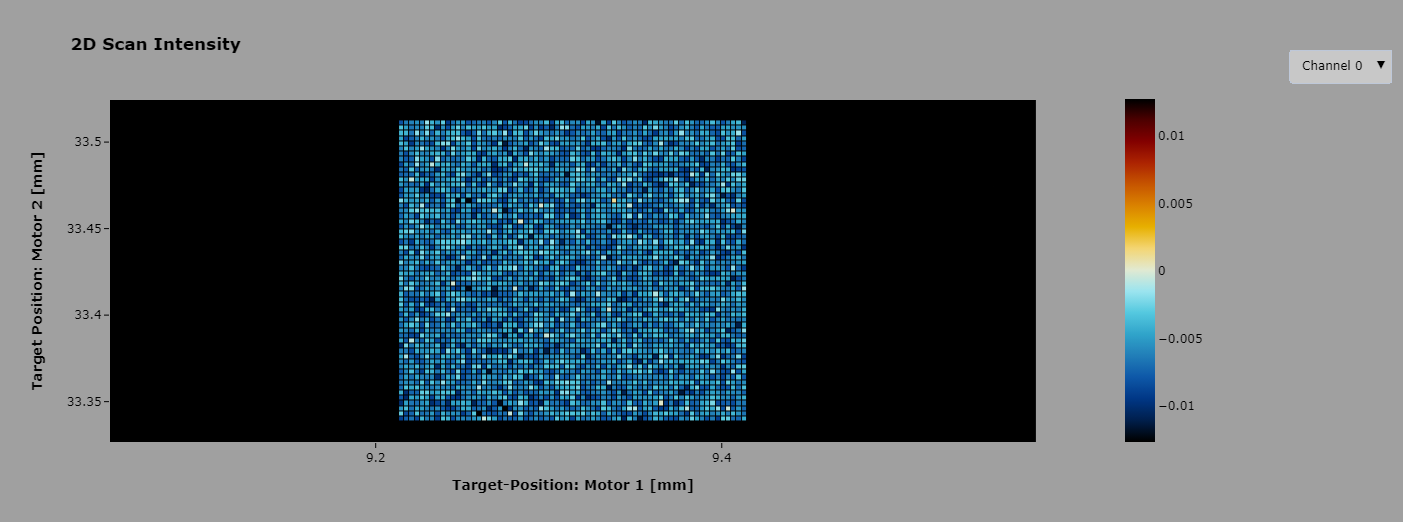

In [98]:
### import plotly.graph_objects as go
# go objects are grouped into 'one-indexed' subplot rows
# Set hmap magnification, fixed ratio
mag_factor = 9

# Set base figure for subplots
fig = make_subplots(rows = 1, #Display how many rows of objects 
                    cols = 1, #Display how many side-by-side?
                    #subplot_titles = [list_of_strings],
                    specs=[[{'secondary_y':True}]],
                    shared_xaxes = False,
                    shared_yaxes = False)

# Add heatmap traces for each channel
for ch in range(nchannels):
    df = data_to_plot[ch]
    fig.add_trace(go.Heatmap(x = df.columns,
                             xgap = 1,
                             y = df.index,
                             ygap = 1,
                             z = df, # Signal data of channel = ch
                             zmin = signal_mins[ch], # Specify or plotly defaults to df min/max
                             zmid = 0,
                             #zmax = signal_maxs[ch],
                             #colorbar_title = f'<b>Ch {ch}<b>',
                             #colorbar_tickcolor = 'black',
                             colorbar_len = 1.06,
                                         #'xpad': 100},
                                         #'x': cbar_xlocs[ch],
                                         #'y': cbar_ylocs[ch],
                             colorscale ='icefire'),
                  #row = mth_row,
                  #col = nth_col,
                  #name = f'Channel {ch}',
                  secondary_y = False)
#########################################################################################################################################
# Update layout by embedding dropdown buttons in the updatemenu
dropdown_buttons = []
for ch in range(nchannels):
    dropdown_buttons.append({'label': f'Channel {ch}',
                             'method': 'update',
                             'args': [
                                      {'visible': [idx==ch for idx in range(nchannels)] },
                                      {'title': '<b>2D Scan Intensity<b>'}
                                     ]
                            })
    
# Initial display: Hide all traces after channel zero
for i in range(1, nchannels):
    fig.data[i].visible = False

# Implement a dropdown button
fig.update_layout(
                  {'updatemenus': [{'type': 'dropdown',
                                    'x': 1.3, # Position floats 
                                    'y': 1.15, # Position floats 
                                    'showactive': True, # Active buttons are highlighted
                                    'active': 0, # Determines initial 'active' channel
                                    'bgcolor': 'rgb(200,200,200)',
                                    'direction': 'down',
                                    'buttons': dropdown_buttons}] 
                  }) 
######################################################################################################################################
## Add secondary axes
#fig.add_trace(go.Heatmap(x = df.columns,
#                         y = time_ax2, # Tau Delay-Axis (Motor-2), displayed 'Right'
#                         z = df, # Signal data of channel = ch
#                         #zmin = signal_mins[ch], # Specify or plotly defaults to df min/max 
#                         #zmax = signal_maxs[ch],
#                         colorscale = 'icefire'),
#              #row = mth_row,
#              #col = nth_col,
#              #yaxis = 'y2',
#              secondary_y = True)

# Format Axes
fig.update_layout(
                  {'xaxis':{'title' : {'text' : '<b>Target-Position: Motor 1 [mm]<b>'},
                            #'tickmode': 'auto',
                            'nticks' : 5,
                            'ticks' : 'outside',
                            'tickson': 'boundaries',
                            #'tick0': motor_labels[1][0],
                            #'dtick': round(step1_space, 3)*11,# *num_m1steps*.5,
                            'showticklabels': True,
                            'color' : 'black',
                            #'linecolor': 'black',
                            #'tickcolor': 'black',
                            #'gridcolor': 'black',
                            'showline': False,
                            'showgrid': False,
                            #'scaleanchor': 'y',
                            #'scaleratio': 1,
                            'range' : [m1_position_min-(round(step1_space, 3)/2), m1_position_max+(round(step1_space, 3)/2)] },
                   'yaxis':{'title' : {'text' : '<b>Target Position: Motor 2 [mm]<b>'},
                            #'tickmode': 'linear',
                            'nticks': 5,
                            'tickson': 'boundaries',
                            'color' : 'black',
                            #'gridcolor': 'black',
                            'showgrid': False,
                            #'tick0': motor_labels[2][0],
                            #'dtick': round(step2_space, 3)*11,# *num_m1steps*.43,
                            'showline': False,
                            'scaleanchor': 'x',
                            'scaleratio': 1,
                            'range' : [m2_position_min-(round(step2_space,3)/2), m2_position_max+(round(step2_space,3)/2)] },
                   'coloraxis':{'colorbar':{'xpad' : 300,
                                'ypad' : 300,} },
                                #'bgcolor' : 'black',
                                #'bordercolor' : 'black',
                                #'outlinecolor' : 'black',
                                #'tickcolor' : 'black',
                  },
                  paper_bgcolor = 'rgb(160,160,160)',
                  plot_bgcolor = 'black',
                  title_text = '<b>2D Scan Intensity<b>',
                  font_color = 'black',
                  margin_autoexpand = True,
                  margin_l = 110,
                  #aspectratio = dict(x=1, y=1, z=0.7),
                  #aspectmode = 'manual',
                  width = num_m1steps*mag_factor,
                  height = num_m2steps*mag_factor)

#fig.update_xaxes(showticklabels=True, 
                 #showgrid = True,)
                 #ticks = 'outside')
fig.update_yaxes(showticklabels=True, 
                 ticks = 'outside',
                 showgrid = False,
                 secondary_y = False)
fig.update_coloraxes(colorbar_xpad = 300,
                     colorbar_ypad = 300,
                     colorbar_bgcolor = 'black',
                     colorbar_bordercolor = 'black',
                     colorbar_outlinecolor = 'black',
                     colorbar_tickcolor = 'black')

#fig.update_yaxes(title_text = 'Time Delay: Drive to Probe [fs]',
#                 #showgrid = True,
#                 #showticklabels=True, 
#                 #ticks = 'outside',
#                 #tickson = 'boundaries',
#                 #ticklen = 10,
#                 secondary_y = True)

#fig.write_html('first_figure.html', auto_open=True)
fig.show()

### Figure
> Plotly interactivity limits functionality of buttons. With Dash, callbacks may be leveraged to produce more dynamic visuals for analytics.

[ go back to the top ](#table-of-contents)

---
#### Input time-zero

In [24]:
# # Even-Parity Medians
# from statistics import median
# if (num_m1steps%2) == 0:
#     step1_med = num_m1steps/2
# # Odd-Parity Medians
# elif (num_m1steps%2) != 0:
#     step1_med = median(m1_positions)
#     
# # Odd-Parity Medians
# if (num_m2steps%2) == 0:
#     step2_med = num_m2steps/2
# elif (num_m2steps%2) != 0:
#     step2_med = median(m2_positions)
# 
# # Median indices
# m1_positions.index(median(m1_positions))

m1_zero = 9.314
#m1_zero = float(input('Which Motor-1 position corresponds with time-zero? '))
if m1_zero not in m1_positions:
    while m1_zero not in m1_positions:
        m1_zero = float(input(f'{m1_zero} is an invalid Motor-1 position.\nPlease enter the valid Motor-1 position corresponding with time-zero: '))

m2_zero = 33.421
#m2_zero = float(input('Which Motor-2 position corresponds with time-zero? '))
if m2_zero not in m1_positions:
    while m2_zero not in m2_positions:
        m2_zero = float(input(f'{m2_zero} is an invalid Motor-2 position.\nPlease enter the valid Motor-2 position corresponding with time-zero: '))

In [43]:

# Motor-2: Drive-Probe Time Delay Axis-2 (dephasing)
time_ax2 = np.round( ((df.index - m2_zero)/step2_space)*step2_time, 1)

In [86]:
step1_time

20.0

In [91]:
[time_ax1[0]-(step1_time/2), time_ax1[-1]+(step1_time/2)]

[-990.0, 350.0]

In [89]:
m1_zero = 9.362

In [90]:
# Motor-1: Pump-Probe Time Delay Axis-1
time_ax1 = np.round( ((df.columns-m1_zero)/step1_space)*step1_time, 1)
time_ax1

Float64Index([-980.0, -960.0, -940.0, -920.0, -900.0, -880.0, -860.0, -840.0,
              -820.0, -800.0, -780.0, -760.0, -740.0, -720.0, -700.0, -680.0,
              -660.0, -640.0, -620.0, -600.0, -580.0, -560.0, -540.0, -520.0,
              -500.0, -480.0, -460.0, -440.0, -420.0, -400.0, -380.0, -360.0,
              -340.0, -320.0, -300.0, -280.0, -260.0, -240.0, -220.0, -200.0,
              -180.0, -160.0, -140.0, -120.0, -100.0,  -80.0,  -60.0,  -40.0,
               -20.0,    0.0,   20.0,   40.0,   60.0,   80.0,  100.0,  120.0,
               140.0,  160.0,  180.0,  200.0,  220.0,  240.0,  260.0,  280.0,
               300.0,  320.0,  340.0],
             dtype='float64', name='motor-target_1')

---

# <a id='figure2'></a>Plotly Figure 2
Plotly Figure 2

> option 3


[go back to the top](#table-of-contents)

In [26]:
from jupyter_dash import JupyterDash
from jupyterthemes import jtplot

jtplot.style(theme='solarizedd', context='notebook', ticks=True, grid=False)

In [37]:
m1_zero

9.314

In [41]:
time_ax1

Float64Index([-660.5, -640.4, -620.4, -600.4, -580.4, -560.4, -540.4, -520.4,
              -500.3, -480.3, -460.3, -440.3, -420.3, -400.3, -380.3, -360.2,
              -340.2, -320.2, -300.2, -280.2, -260.2, -240.2, -220.2, -200.1,
              -180.1, -160.1, -140.1, -120.1, -100.1,  -80.1,  -60.0,  -40.0,
               -20.0,    0.0,   20.0,   40.0,   60.0,   80.1,  100.1,  120.1,
               140.1,  160.1,  180.1,  200.1,  220.2,  240.2,  260.2,  280.2,
               300.2,  320.2,  340.2,  360.2,  380.3,  400.3,  420.3,  440.3,
               460.3,  480.3,  500.3,  520.4,  540.4,  560.4,  580.4,  600.4,
               620.4,  640.4,  660.5],
             dtype='float64', name='motor-target_1')

In [40]:
x_range = [time_ax1[0]-(round(step1_time, 3)/2), time_ax1[-1]+(round(step1_time, 3)/2)]
x_range

[-670.507, 670.507]

In [38]:
m2_zero

33.421

In [ ]:

y_range = [time_ax2[0]-(round(step2_time, 3)/2), time_ax2[-1]+(round(step2_time, 3)/2)]

In [97]:
ls = [50, 55, 57, 58, 60]
t = 174
ntowns = len(ls)

In [124]:
(option4_slctd==0)|(option4_slctd==None)

False

In [126]:
option4_slctd =0
option6_slctd ='y2'

In [127]:
option4_slctd in ['x', 'x2']

False

0 <class 'int'>
scan_avg_all <class 'str'>
None <class 'NoneType'>
None <class 'NoneType'>
0 <class 'int'>
scan_avg_all <class 'str'>
None <class 'NoneType'>
None <class 'NoneType'>
0 <class 'int'>
scan_avg_all <class 'str'>
None <class 'NoneType'>
None <class 'NoneType'>
0 <class 'int'>
scan_avg_all <class 'str'>
None <class 'NoneType'>
None <class 'NoneType'>
0 <class 'int'>
scan_avg_all <class 'str'>
None <class 'NoneType'>
None <class 'NoneType'>
0 <class 'int'>
scan_avg_all <class 'str'>
None <class 'NoneType'>
None <class 'NoneType'>
0 <class 'int'>
scan_avg_all <class 'str'>
None <class 'NoneType'>
None <class 'NoneType'>
0 <class 'int'>
scan_avg_all <class 'str'>
None <class 'NoneType'>
None <class 'NoneType'>
0 <class 'int'>
scan_avg_all <class 'str'>
None <class 'NoneType'>
None <class 'NoneType'>
0 <class 'int'>
scan_avg_all <class 'str'>
None <class 'NoneType'>
None <class 'NoneType'>
4 <class 'int'>
scan_avg_all <class 'str'>
None <class 'NoneType'>
None <class 'NoneType'>

In [131]:
### Build the app
# app = dash.Dash(__name__)
app = JupyterDash(__name__)
# ------------------------------------------------------------------------------
# App layout:
# 1. Dash components(i.e. graphs, dropdowns, checkboxes, etc.)
# 2. Any HTML needed in there (i.e)
# ------------------------------------------------------------------------------
app.layout = html.Div([
    # Add a title(H1) on the webpage aligned to the center of the page
    html.H1("Ultrafast Transient Polarization Spectroscopy(UTPS)", style={'text-align': 'center'}),
    # Add a dropdown button
    dcc.Dropdown(id = 'slct_channel',
                 # 'label' key: what Dash displays to app users
                 # 'value' key: dtype must match data-dtypes
                 options=[{'label': f'Channel {ch}', 'value': ch} for ch in range(nchannels)],
                 multi=False,
                 value=0,
                 style={'width': '30%'},
                 clearable = False,
                 ),
    # Add a 2nd dropdown button
    dcc.Dropdown(id = 'slct_scan',
                 # 'label' key: what Dash displays to app users
                 # 'value' key: dtype must match data-dtypes
                 options=[{'label': list(data_dict.keys())[scn].replace('#', ': #').replace('_', ' ').capitalize(),
                           'value': list(data_dict.keys())[scn]} for scn in range(len(data_dict))],
                 multi=False,
                 value=list(data_dict.keys())[0],
                 style={'width': '30%'},
                 clearable = False,
                 ),
    # Add a 3rd dropdown button
    dcc.Dropdown(id="slct_timeaxis1",
                 # Options that the user sees "label"
                 # Value of the key 'value' matches dataframe dtype
                 options=[{'label': m1_positions[i],
                           'value': m1_positions[i],} for i in range(num_m1steps)],
                 multi=False,
                 value=0,
                 style={'width': '30%'},
                 clearable = True,
                 ),
    # Add a 4th button, 1st radio-item
    dcc.RadioItems(id='slct_x2',
                   options=[
                       {'label': 'T','value':'x'},
                       {'label': 'Add M1','value':'x2'}
                   ],
                    value='x',
                    style={'width':'50%'}),
    # Add a 5th button, 4th dropdown
    dcc.Dropdown(id="slct_timeaxis2",
                 # Options that the user sees "label"
                 # Value of the key 'value' matches dataframe dtype
                 options=[{'label': m2_positions[i],
                           'value': m2_positions[i],} for i in range(num_m2steps)],
                 multi=False,
                 value=0,
                 style={'width': '30%'},
                 clearable = True,
                 ),
    # Add a 6th button, 2nd radio-item
    dcc.RadioItems(id='slct_y2',
                   options=[
                       {'label': 'Tau-axis only','value':'y'},
                       {'label': 'Add M2-axis','value':'y2'}
                   ],
                   value='y',
                   style={'width': '50%'}),
    
    # Add an "HTML5 content division element, <div>" w/ the "Div" wrapper
    # Used to group content for styling with class and id attributes
    # https://dash.plotly.com/dash-html-components/div
    # https://developer.mozilla.org/en-US/docs/Web/HTML/Element/div
    html.Br(),
    # 'children=[]' is an unnecessary explicit argument for understanding the app.callback output
    html.Div(id='output_container', children=[]),
    # Break adds a space between Div and Graph
    html.Br(),
    # Initialize an empty graph object
    # 'figure={}' is an unnecessary explicit argument for understanding the app.callback output
    # Essentially figure = fig below, empty {} allows for interactive fig assignment
    dcc.Graph(id='2d_scan_surf', figure={})
                ])

# ------------------------------------------------------------------------------
# TIP: Connect the Plotly graphs with Dash Components inside app.layout
# NOTE: Multiple outputs, single input (taking info from only one dropdown)
# [] Brackets only required for multiple input/output objects
@app.callback(
    # Output_container is the <div>, the 'children' of the output_container will be output
    # Returned component_property, 'children', from update_graph function, must be in form of a list
    [Output(component_id='output_container', component_property='children'),
     # Output to the empty graph, the 'figure' of the graph will be output
     # Returned component_property, 'figure', from update_graph function, must be in form of a Dict
     Output(component_id='2d_scan_surf', component_property='figure')],
    # Input is what goes into the 'figure={}' dictionary in the app.layout
    [Input(component_id='slct_channel', component_property='value'),
     Input(component_id='slct_scan', component_property='value'),
     Input(component_id='slct_timeaxis1', component_property='value'),
     Input(component_id='slct_x2', component_property='value'),
     Input(component_id='slct_timeaxis2', component_property='value'),
     Input(component_id='slct_y2', component_property='value')]
)
# A callback function definition is required for each app.callback
# Each argument connects to one Input's 'component_property = value'
def update_graph(option1_slctd, option2_slctd, option3_slctd, option4_slctd, option5_slctd, option6_slctd):
    # Just good practice to print out here to debug
    print(option4_slctd, type(option4_slctd))
    print(option6_slctd, type(option6_slctd))

    
    # Set base figure for subplots
    fig = make_subplots(rows = 1, #Display how many rows of objects 
                        cols = 1, #Display how many side-by-side?
                        #subplot_titles = [list_of_strings],
                        specs=[[{'secondary_y':True}]],
                        shared_xaxes = False,
                        shared_yaxes = False)
    
    # Create a string-object called 'container', returned below
    container = 'Time-Delay Heatmap: {} Motor-1 Position for time-overlap'.format(option3_slctd)
    
    # Modify formatted data dictionary for user input
    ddf = data_dict.copy()
    ddf = data_dict[option2_slctd][option1_slctd]
    time_and_space1 = None
    time_and_space2 = None

    # Display Motor-X Positions
    if ( option3_slctd in [0, None] )&( option5_slctd in [0, None] ):
        xdata = ddf.columns
        ydata = ddf.index
        x_title_txt = '<b>Target-Position: Motor 1 [mm]<b>'
        y_title_txt = '<b>Target Position: Motor 2 [mm]<b>'
        x_range = [m1_position_min-(step1_space/2), m1_position_max+(step1_space/2)]
        y_range = [m2_position_min-(step2_space/2), m2_position_max+(step2_space/2)]
                
    # Display Pump-Probe Time-Delay Axis: T (from Motor-1 scans)
    elif (option3_slctd>0) & (option5_slctd in [0,None]):
        m1_zero = option3_slctd
        time_ax1 = np.round( ((ddf.columns-m1_zero)/step1_space)*step1_time, 1)
        xdata = time_ax1
        ydata = ddf.index
        x_title_txt = '<b>Pump-Probe Delay [fs]<b>'
        y_title_txt = '<b>Target Position: Motor 2 [mm]<b>'
        x_range = [time_ax1[0]-(step1_time/2), time_ax1[-1]+(step1_time/2)]   
        y_range = [m2_position_min-(step2_space/2), m2_position_max+(step2_space/2)]

    # Display Drive-Probe Time-Delay Axis: TAU (from Motor-2 scans)
    elif (option3_slctd in [0,None]) & (option5_slctd>0):
        m2_zero = option5_slctd
        time_ax2 = np.round( ((ddf.index-m2_zero)/step2_space)*step2_time, 1)
        xdata = ddf.columns
        ydata = time_ax2
        x_title_txt = '<b>Target Position: Motor 1 [mm]<b>'
        y_title_txt = '<b>Drive-Probe Delay [fs]<b>'
        x_range = [m1_position_min-(step1_space/2), m1_position_max+(step1_space/2)]
        y_range = [time_ax2[0]-(step2_time/2), time_ax2[-1]+(step2_time/2)]
        
    # Display Both Time-Delay Axes: T & TAU
    elif (option3_slctd > 0) & (option5_slctd > 0):
        m1_zero = option3_slctd
        m2_zero = option5_slctd
        time_ax1 = np.round( ((ddf.columns-m1_zero)/step1_space)*step1_time, 1)
        time_ax2 = np.round( ((ddf.index-m2_zero)/step2_space)*step2_time, 1)
        xdata = time_ax1
        ydata = time_ax2
        x_title_txt = '<b>Pump-Probe Delay [fs]<b>'
        y_title_txt = '<b>Drive-Probe Delay [fs]<b>'
        x_range = [time_ax1[0]-(step1_time/2), time_ax1[-1]+(step1_time/2)]
        y_range = [time_ax2[0]-(step2_time/2), time_ax2[-1]+(step2_time/2)]
    
        
    # Plotly Graph Objects (GO)
    fig.add_trace(
    #fig = go.Figure(
        go.Heatmap(x = xdata,
                   y = ydata,
                   z = ddf,
                   xgap = 1,
                   ygap = 1,
                   zmin = signal_mins[option1_slctd], # Defaults to DF min/max
                   zmid = 0,
                   #hover_name = option1_slctd,#hname,
                   #zmax = signal_maxs[ch],
                   visible = True,
                   # colorbar_title = f'<b>Ch {ch}<b>',
                   # colorbar_tickcolor = 'black',
                   colorbar_len = 1.06,
                   # colorbar_xpad = 100,
                   # colorbar_x = cbar_xlocs[ch],
                   # colorbar_y = cbar_ylocs[ch],
                   colorscale ='icefire'
                  ),
            secondary_y = False #time-delay only
                )
    
    # RadioItem activation click
    reference_xaxis = option4_slctd # 'x2' for secondary axis
    reference_yaxis = option6_slctd # 'y2' for secondary axis
    
    # SECONDARY X-AXIS, display both Motor-1 Position & Time-Delay: T "Pump-Probe"
    if reference_xaxis == 'x2':
        x2_title_txt = '<b>Target Position: Motor 1 [mm]<b>'
        x2_range = [m1_position_min-(step1_space/2), m1_position_max+(step1_space/2)]
        time_and_space1 = {'title' : {'text' : x2_title_txt},
                           'overlaying':'x',
                           'side': 'top',
                           #'tickmode': 'linear',
                           'nticks': 5,
                           'ticks': 'outside',
                           'tickson': 'boundaries',
                           'color' : 'black',
                           #'gridcolor': 'black',
                           'showline': False,
                           'showgrid': False,
                           'zeroline': False,
                           #'tick0': motor_labels[2][0],
                           #'dtick': round(step2_space, 3)*11,# *num_m1steps*.43,
                           #'scaleanchor': 'y',
                           #'scaleratio': 1,
                           'range' : x2_range }
        
    # SECONDARY Y-AXIS, display both Motor-2 Position & Time-Delay: Tau "Drive-Probe"
    if reference_yaxis == 'y2':
        y2_title_txt = '<b>Target Position: Motor 2 [mm]<b>'
        y2_range =  [m2_position_min-(step2_space/2), m2_position_max+(step2_space/2)]
        time_and_space2 = {'title' : {'text' : y2_title_txt},
                           'overlaying':'y',
                           'side': 'right',
                           #'tickmode': 'linear',
                           'nticks': 5,
                           'ticks': 'outside',
                           'tickson': 'boundaries',
                           'color' : 'black',
                           #'gridcolor': 'black',
                           'showline': False,
                           'showgrid': False,
                           'zeroline': False,
                           #'tick0': motor_labels[2][0],
                           #'dtick': round(step2_space, 3)*11,# *num_m1steps*.43,
                           #'scaleanchor': 'y',
                           #'scaleratio': 1,
                           'range' : y2_range }
    if (  reference_xaxis=='x2')&(reference_yaxis=='y'):
        xdata = ddf.columns
    elif (reference_xaxis=='x')&(reference_yaxis=='y2'):
        ydata = ddf.index
    elif (reference_xaxis=='x2')&(reference_yaxis=='y2'):
        xdata = ddf.columns
        ydata = ddf.index
        
        # Plotly Graph Objects (GO)
        fig.add_trace(
            #fig = go.Figure(
            go.Heatmap(x = xdata,
                       y = ydata,
                       z = ddf,
                       xaxis = reference_xaxis, # 'x'(default) or 'x2': Secondary x-axis for Motor-1
                       yaxis = reference_yaxis, # 'y'(default) or 'y2': Secondary y-axis for Motor-2
                       xgap = 1,
                       ygap = 1,
                       zmin = signal_mins[option1_slctd], # Defaults to DF min/max
                       zmid = 0,
                       #hover_name = option1_slctd,#hname,
                       #zmax = signal_maxs[ch],
                       visible = True,
                       # colorbar_title = f'<b>Ch {ch}<b>',
                       # colorbar_tickcolor = 'black',
                       colorbar_len = 1.06,
                       # colorbar_xpad = 100,
                       # colorbar_x = cbar_xlocs[ch],
                       # colorbar_y = cbar_ylocs[ch],
                       colorscale ='icefire'
                      ),
                secondary_y = True#time_and_space
                    )


    # Format Axes
    fig.update_layout(
        {'xaxis':{'title' : {'text' : x_title_txt},
                #'tickmode': 'auto',
                'nticks' : 5,
                'ticks' : 'outside',
                'tickson': 'boundaries',
                #'tick0': motor_labels[1][0],
                #'dtick': round(step1_space, 3)*11,# *num_m1steps*.5,
                'showticklabels': True,
                'color' : 'black',
                #'linecolor': 'black',
                #'tickcolor': 'black',
                #'gridcolor': 'black',
                'showline': False,
                'showgrid': False,
                'zeroline': False,
                #'scaleanchor': 'y',
                #'scaleratio': 1,
                'range' : x_range },
        'yaxis':{'title' : {'text' : y_title_txt},
                #'tickmode': 'linear',
                'nticks': 5,
                'ticks': 'outside',
                'tickson': 'boundaries',
                'color' : 'black',
                #'gridcolor': 'black',
                'showline': False,
                'showgrid': False,
                'zeroline': False,
                #'tick0': motor_labels[2][0],
                #'dtick': round(step2_space, 3)*11,# *num_m1steps*.43,
                'scaleanchor': 'y',
                'scaleratio': 1,
                'range' : y_range },
        'xaxis2': time_and_space1, # None (default) or 
        'yaxis2': time_and_space2, # None (default) or 
        'coloraxis':{'colorbar':{'xpad' : 300,
                    'ypad' : 300,} },
                    #'bgcolor' : 'black',
                    #'bordercolor' : 'black',
                    #'outlinecolor' : 'black',
                    #'tickcolor' : 'black',
        },
        paper_bgcolor = 'rgb(160,160,160)',
        plot_bgcolor = 'black',
        title_text = '<b>2D Scan Intensity<b>',
        font_color = 'black',
        margin_autoexpand = True,
        margin_l = 110,
        #aspectratio = dict(x=1, y=1, z=0.7),
        #aspectmode = 'manual',
        width = num_m1steps*mag_factor,
        height = num_m2steps*mag_factor)
        
    ## Display TIme Delay Axis
    #elif option3_slctd > 0:
    #    #=============================================================================================
    #    #m1_zero = option3_slctd
    #    #m2_zero = 33
    #    # m1_zero = float(input('Which Motor-1 position corresponds with time-zero? '))
    #    # if m1_zero not in m1_positions:
    #    #     while m1_zero not in m1_positions:
    #    #         m1_zero = float(input(f'{m1_zero} is an invalid Motor-1 position.\nPlease enter the valid Motor-1 position corresponding with time-zero: '))
    #    #         
    #    # m2_zero = float(input('Which Motor-2 position corresponds with time-zero? '))
    #    # if m2_zero not in m1_positions:
    #    #     while m2_zero not in m2_positions:
    #    #         m2_zero = float(input(f'{m2_zero} is an invalid Motor-2 position.\nPlease enter the valid Motor-2 position corresponding with time-zero: '))
    #        
    #    #----------------------------------------------------------------------------------------------
    #    #time_ax1 = np.round( (ddf.columns-m1_zero)/round(step1_space,3)*step1_time, 1)
    #    #time_ax2 = np.round( (ddf.index - m2_zero)/round(step2_space,3)*step2_time, 1)
    #==============================================================================================
    # What is returned here will actually go to the output
    # First:  'component_property = children'
    # Second: 'component_property =   figure'
    return container, fig
# ------------------------------------------------------------------------------
if __name__ == '__main__':
    #app.run_server(debug=False) #http://127.0.0.1:8050/
    # Run app and display result inline in the notebook
    app.run_server(mode='inline')

x <class 'str'>
y <class 'str'>
x2 <class 'str'>
y <class 'str'>
x2 <class 'str'>
y2 <class 'str'>
x2 <class 'str'>
y <class 'str'>
x2 <class 'str'>
y2 <class 'str'>
x <class 'str'>
y2 <class 'str'>
x2 <class 'str'>
y2 <class 'str'>
x2 <class 'str'>
y <class 'str'>
x2 <class 'str'>
y2 <class 'str'>
x2 <class 'str'>
y <class 'str'>
x <class 'str'>
y <class 'str'>
x2 <class 'str'>
y <class 'str'>
x <class 'str'>
y <class 'str'>
x <class 'str'>
y2 <class 'str'>
x <class 'str'>
y <class 'str'>
x <class 'str'>
y2 <class 'str'>
x <class 'str'>
y <class 'str'>
x <class 'str'>
y2 <class 'str'>
x <class 'str'>
y <class 'str'>
x <class 'str'>
y2 <class 'str'>
x <class 'str'>
y <class 'str'>
x <class 'str'>
y2 <class 'str'>
x <class 'str'>
y <class 'str'>
x <class 'str'>
y2 <class 'str'>
x2 <class 'str'>
y2 <class 'str'>
x <class 'str'>
y2 <class 'str'>
x2 <class 'str'>
y2 <class 'str'>
x2 <class 'str'>
y2 <class 'str'>
x2 <class 'str'>
y <class 'str'>
x2 <class 'str'>
y2 <class 'str'>
x2 <class 

[ go back to the top ](#table-of-contents)

---

<a id = 'figure3'></a>

# Figure 3: Example

> Not my figure

[go back to the top](#Table-of-contents)

In [28]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

#app=   dash.Dash(__name__,external_stylesheets=external_stylesheets)
app = JupyterDash(__name__,external_stylesheets=external_stylesheets)

df = pd.read_csv('https://plotly.github.io/datasets/country_indicators.csv')

available_indicators = df['Indicator Name'].unique()

app.layout = html.Div([
    html.Div([

        html.Div([
            dcc.Dropdown(
                id='xaxis-column',
                options=[{'label': i, 'value': i} for i in available_indicators],
                value='Fertility rate, total (births per woman)'
            ),
            dcc.RadioItems(
                id='xaxis-type',
                options=[{'label': i, 'value': i} for i in ['Linear', 'Log']],
                value='Linear',
                labelStyle={'display': 'inline-block'}
            )
        ],
        style={'width': '48%', 'display': 'inline-block'}),

        html.Div([
            dcc.Dropdown(
                id='yaxis-column',
                options=[{'label': i, 'value': i} for i in available_indicators],
                value='Life expectancy at birth, total (years)'
            ),
            dcc.RadioItems(
                id='yaxis-type',
                options=[{'label': i, 'value': i} for i in ['Linear', 'Log']],
                value='Linear',
                labelStyle={'display': 'inline-block'}
            )
        ],style={'width': '48%', 'float': 'right', 'display': 'inline-block'})
    ]),

    dcc.Graph(id='indicator-graphic'),

    dcc.Slider(
        id='year--slider',
        min=df['Year'].min(),
        max=df['Year'].max(),
        value=df['Year'].max(),
        marks={str(year): str(year) for year in df['Year'].unique()},
        step=None
    )
])

@app.callback(
    Output('indicator-graphic', 'figure'),
    Input('xaxis-column', 'value'),
    Input('yaxis-column', 'value'),
    Input('xaxis-type', 'value'),
    Input('yaxis-type', 'value'),
    Input('year--slider', 'value'))
def update_graph(xaxis_column_name, yaxis_column_name,
                 xaxis_type, yaxis_type,
                 year_value):
    dff = df[df['Year'] == year_value]

    fig = px.scatter(x=dff[dff['Indicator Name'] == xaxis_column_name]['Value'],
                     y=dff[dff['Indicator Name'] == yaxis_column_name]['Value'],
                     hover_name=dff[dff['Indicator Name'] == yaxis_column_name]['Country Name'])

    fig.update_layout(margin={'l': 40, 'b': 40, 't': 10, 'r': 0}, hovermode='closest')

    fig.update_xaxes(title=xaxis_column_name,
                     type='linear' if xaxis_type == 'Linear' else 'log')

    fig.update_yaxes(title=yaxis_column_name,
                     type='linear' if yaxis_type == 'Linear' else 'log')

    return fig
# # ------------------------------------------------------------------------------
if __name__ == '__main__':
    # app.run_server(debug=False) # http://127.0.0.1:8050/
    
    # Run app and display result inline in the notebook
    app.run_server(mode='inline')

0 <class 'int'>
scan_avg_all <class 'str'>
0 <class 'int'>
0 <class 'int'>


---

<a id='figure4'></a>

# Figure 4 Subplots

[[ go back to the top ]](#Table-of-contents)

This is the format of your plot grid:
[ (1,1) x,y   ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]
[ (4,1) x7,y7 ]  [ (4,2) x8,y8 ]



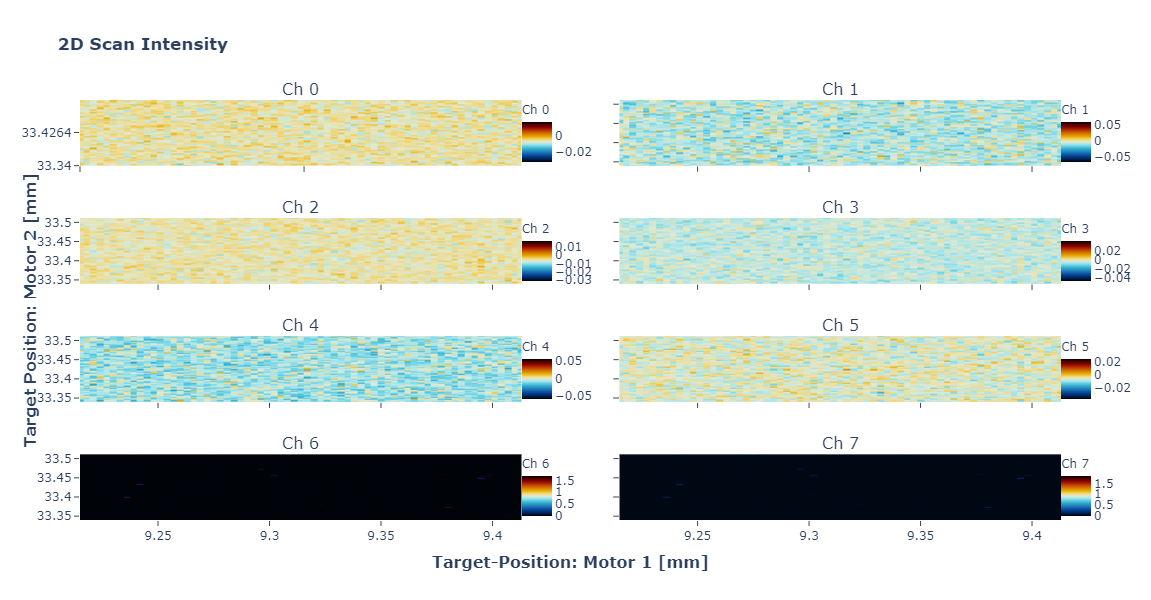

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-27-3a9c126a9ca2> in update_graph(
    option1_slctd=0,
    option2_slctd='scan_avg_all',
    option3_slctd=0,
    option4_slctd=0
)
    143     # Plotly Graph Objects (GO)
    144     fig = go.Figure(
--> 145         go.Heatmap(x = xdata,
        global go.Heatmap = <class 'plotly.graph_objs._heatmap.Heatmap'>
        global x = undefined
        xdata = Float64Index([9.215, 9.218, 9.221, 9.224, 9.227,  9.23, 9.233, 9.236, 9.239,
              9.242, 9.245, 9.248, 9.251, 9.254, 9.257,  9.26, 9.263, 9.266,
              9.269, 9.272, 9.275, 9.278, 9.281, 9.284, 9.287,  9.29, 9.293,
              9.296, 9.299, 9.302, 9.305, 9.308, 9.311, 9.314, 9.317,  9.32,
              9.323, 9.326, 9.329, 9.332, 9.335, 9.338, 9.341, 9.344, 9.347,
               9.35, 9.353, 9.356, 9.359, 9.362, 9.365, 9.368, 9.371, 9.374,
              

In [29]:
### import plotly.graph_objects as go

#https://plotly.com/python-api-reference/generated/plotly.graph_objects.Figure.html
#https://plotly.github.io/plotly.py-docs/generated/plotly.graph_objects.Heatmap.html
#https://plotly.com/python-api-reference/generated/plotly.graph_objects.Layout.html#plotly.graph_objects.Layout
#https://plotly.com/python-api-reference/generated/plotly.subplots.make_subplots.html
#https://plotly.com/python/tick-formatting/
# go objects are grouped into 'one-indexed' subplot rows
#mth_row = 1
#nth_col = 1
#for row
# Set base figure for subplots
fig = make_subplots(rows = 4, #Display how many rows of objects 
                    cols = 2, #Display how many side-by-side?
                    subplot_titles = ['Ch 0', 'Ch 1', 'Ch 2', 'Ch 3',
                                      'Ch 4', 'Ch 5', 'Ch 6', 'Ch 7'],
                    #specs=[[{'secondary_y':False}, {'secondary_y':False}],
                    #       [{'secondary_y':False}, {'secondary_y':False}],
                    #       [{'secondary_y':False}, {'secondary_y':False}],
                    #       [{'secondary_y':False}, {'secondary_y':False}] ],
                    shared_xaxes = 'all',
                    shared_yaxes = 'all',
                    x_title = '<b>Target-Position: Motor 1 [mm]<b>',
                    y_title = '<b>Target Position: Motor 2 [mm]<b>',
                    print_grid = True,
                    start_cell = 'top-left')

###################################################################################################
loc_dict = {0: [1,1], 1: [1,2],
            2: [2,1], 3: [2,2],
            4: [3,1], 5: [3,2],
            6: [4,1], 7: [4,2]}

cbar_xlocs = [0.44, 0.99, 0.44, 0.99, 0.44, 0.99, 0.44, 0.99]
cbar_ylocs = [0.925, 0.925, 0.64, 0.64, 0.36, 0.36, 0.08, 0.08]

for ch in range(8):
    df = data_to_plot[ch]
    # Add heatmap trace to subplot
    fig.add_trace(go.Heatmap(x = df.columns,
                             #xaxis = 'x',
                             xgap = 0,
                             y = df.index,
                             #yaxis = 'y',
                             ygap = 0,
                             z = df, # Signal data of channel = ch
                             zmin = signal_mins[ch], # Specify or plotly defaults to df min/max
                             zmax = signal_maxs[ch],
                             colorscale = 'icefire',
                             colorbar = {'title': f'Ch {ch}',
                                         'len': 0.19,
                                         'x': cbar_xlocs[ch],
                                         'y': cbar_ylocs[ch]},
                             showscale = True),
                  row = loc_dict[ch][0],
                  col = loc_dict[ch][1],
                  secondary_y = False)
    # Format Axes
    fig.update_layout({'title':{'text': '<b>2D Scan Intensity<b>'},
                       'xaxis':{'tickmode': 'linear',
                                'tick0': motor_labels[1][0],
                                'dtick': step1_space*num_m1steps*.5,
                                'range' : [m1_position_min, m1_position_max] },
                       'yaxis':{'tickmode': 'linear',
                                'tick0': motor_labels[2][0],
                                'dtick': step1_space*num_m1steps*.43,
                                'range' : [m2_position_min, m2_position_max] },
                      },
                      width = 800,  # num_m1steps*mag_factor,
                      height = 600, # num_m2steps*mag_factor,
                      title_text = '<b>2D Scan Intensity<b>')
###################################################################################################
# # Add secondary axes
# fig.add_trace(go.Heatmap(x = df.columns,
#                          y = time_ax2, # Tau Delay-Axis (Motor-2), displayed 'Right'
#                          z = df, # Signal data of channel = ch
#                          #zmin = signal_mins[ch], # Specify or plotly defaults to df min/max 
#                          #zmax = signal_maxs[ch],
#                          colorscale = 'icefire'),
#               row = mth_row,
#               col = nth_col,
#               secondary_y = True)

# # Format Axes
# fig.update_layout({'title':{'text': '<b>2D Scan Intensity<b>'},
#                    'xaxis':{'title' : {'text' : 'Target-Position: Motor 1 [mm]'},
#                             'tickmode': 'linear',
#                             'tick0': motor_labels[1][0],
#                             'dtick': step1_space*num_m1steps*.5,
#                             'range' : [m1_position_min, m1_position_max] },
#                    'yaxis':{'title' : {'text' : 'Target Position: Motor 2 [mm]'},
#                             'tickmode': 'linear',
#                             'tick0': motor_labels[2][0],
#                             'dtick': step1_space*num_m1steps*.43,
#                             'range' : [m2_position_min, m2_position_max] },
#                   }, height = 600, width = 800, title_text = '<b>2D Scan Intensity<b>')


#fig.update_yaxes(title_text = 'Time Delay: Drive to Probe [fs]', secondary_y = True)
fig.update_xaxes(#showticklabels=True, 
                 ticks = 'outside')
fig.update_yaxes(#showticklabels=True, 
                 ticks = 'outside')

#fig.write_html('first_figure.html', auto_open=True)
# Draw inside label-channel indictor
fig.show()

[[ go back to the top ]](#Table-of-contents)